<a href="https://colab.research.google.com/github/bkrant/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/DS_Unit_2_Sprint_Challenge_3_Classification_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 _Lambda School Data Science Unit 2_
 
 # Classification & Validation Sprint Challenge

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

#### For this Sprint Challenge, you'll predict whether a person's income exceeds $50k/yr, based on census data.

You can read more about the Adult Census Income dataset at the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/adult

#### Run this cell to load the data:

In [0]:
import pandas as pd

columns = ['age', 
           'workclass', 
           'fnlwgt', 
           'education', 
           'education-num', 
           'marital-status', 
           'occupation', 
           'relationship', 
           'race', 
           'sex', 
           'capital-gain', 
           'capital-loss', 
           'hours-per-week', 
           'native-country', 
           'income']

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
                 header=None, names=columns)

df['income'] = df['income'].str.strip()

In [58]:
df.shape

(32561, 15)

In [0]:
import numpy as np
df = df.replace(' ?',np.NaN)

In [60]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

## Part 1 — Begin with baselines

Split the data into an **X matrix** (all the features) and **y vector** (the target).

(You _don't_ need to split the data into train and test sets here. You'll be asked to do that at the _end_ of Part 1.)

In [61]:
X = df.drop(columns=['income'])
y = df['income']
X.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States


What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You can answer this question either with a scikit-learn function or with a pandas function.)
#About 76%

In [62]:
y.value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: income, dtype: float64

What **ROC AUC score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of ROC AUC.)

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred = pd.Series([0]*len(y))
y = y.replace({'<=50K':0, '>50K':1})
roc_auc_score(y, y_pred)

0.5

In this Sprint Challenge, you will use **"Cross-Validation with Independent Test Set"** for your model validaton method.

First, **split the data into `X_train, X_test, y_train, y_test`**. You can include 80% of the data in the train set, and hold out 20% for the test set.

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

X_train.shape, X_test.shape

((26048, 14), (6513, 14))

## Part 2 — Modeling with Logistic Regression!

- You may do exploratory data analysis and visualization, but it is not required.
- You may **use all the features, or select any features** of your choice, as long as you select at least one numeric feature and one categorical feature.
- **Scale your numeric features**, using any scikit-learn [Scaler](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) of your choice.
- **Encode your categorical features**. You may use any encoding (One-Hot, Ordinal, etc) and any library (category_encoders, scikit-learn, pandas, etc) of your choice.
- You may choose to use a pipeline, but it is not required.
- Use a **Logistic Regression** model.
- Use scikit-learn's [**cross_val_score**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function. For [scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules), use **accuracy**.
- **Print your model's cross-validation accuracy score.**

In [0]:
!pip install category_encoders

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [41]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [0]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
target = 'income'

def logistic_regression(X, y, threshold = 0.5, class_weight = {0: 1, 1: 1}):
  pipeline = make_pipeline(
  SimpleImputer(missing_values=np.NaN, strategy='most_frequent'),
  ce.OneHotEncoder(use_cat_names=True), 
  StandardScaler(), 
  LogisticRegression(solver='lbfgs', max_iter=1000, class_weight=class_weight)
  )
  y_pred_proba = cross_val_predict(pipeline, X, y, cv=10, n_jobs=-1, method='predict_proba')[:,1]
  y_pred = y_pred_proba >= threshold
  print(classification_report(y, y_pred))
  confusion_matrix(y, y_pred)
  print(pd.DataFrame(confusion_matrix(y, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive']))
  fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
  plt.plot(fpr, tpr)
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  print('Area under the Receiver Operating Characteristic curve:', roc_auc_score(y, y_pred_proba))
  score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=10).mean()
  print('Cross-Validation Accuracy:', score, '\n', '\n')

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     19775
           1       0.73      0.60      0.66      6273

   micro avg       0.85      0.85      0.85     26048
   macro avg       0.81      0.76      0.78     26048
weighted avg       0.84      0.85      0.84     26048

                 Predicted Negative  Predicted Positive
Actual Negative               18413                1362
Actual Positive                2539                3734
Area under the Receiver Operating Characteristic curve: 0.9046672563550205
Cross-Validation Accuracy: 0.8502379197843396 
 



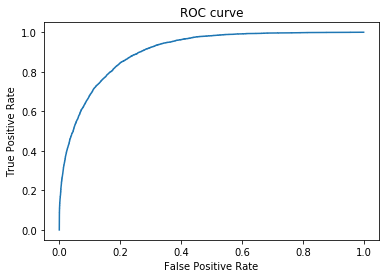

In [72]:
logistic_regression(X_train, y_train)

## Part 3 — Modeling with Tree Ensembles!

Part 3 is the same as Part 2, except this time, use a **Random Forest** or **Gradient Boosting** classifier. You may use scikit-learn, xgboost, or any other library. Then, print your model's cross-validation accuracy score.

In [0]:
def random_forest(X, y, threshold = 0.5, trees=100):
  pipeline = make_pipeline(
  SimpleImputer(missing_values=np.NaN, strategy='most_frequent'),
  ce.OrdinalEncoder(), 
  StandardScaler(),
  RandomForestClassifier(max_depth=None, n_estimators=trees, n_jobs=-1, random_state=42)
  )
  y_pred_proba = cross_val_predict(pipeline, X, y, cv=10, n_jobs=-1, method='predict_proba')[:,1]
  y_pred = y_pred_proba >= threshold
  print(classification_report(y, y_pred))
  confusion_matrix(y, y_pred)
  print(pd.DataFrame(confusion_matrix(y, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive']))
  fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
  plt.plot(fpr, tpr)
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  print('Area under the Receiver Operating Characteristic curve:', roc_auc_score(y, y_pred_proba))
  score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=10).mean()
  print('Cross-Validation Accuracy:', score, '\n', '\n')

              precision    recall  f1-score   support

           0       0.89      0.93      0.91     19775
           1       0.74      0.63      0.68      6273

   micro avg       0.86      0.86      0.86     26048
   macro avg       0.81      0.78      0.79     26048
weighted avg       0.85      0.86      0.85     26048

                 Predicted Negative  Predicted Positive
Actual Negative               18355                1420
Actual Positive                2326                3947
Area under the Receiver Operating Characteristic curve: 0.9061595870811091
Cross-Validation Accuracy: 0.8565729547883029 
 



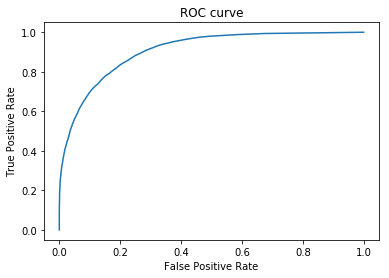

In [76]:
random_forest(X_train, y_train)

In [0]:
def boosting(X, y, threshold = 0.5, trees=100):
  pipeline = make_pipeline(
  SimpleImputer(missing_values=np.NaN, strategy='most_frequent'),
  ce.OrdinalEncoder(), 
  StandardScaler(),
  XGBClassifier(max_depth=1, n_estimators=trees, n_jobs=-1, random_state=42)
  )
  y_pred_proba = cross_val_predict(pipeline, X, y, cv=10, n_jobs=-1, method='predict_proba')[:,1]
  y_pred = y_pred_proba >= threshold
  print(classification_report(y, y_pred))
  confusion_matrix(y, y_pred)
  print(pd.DataFrame(confusion_matrix(y, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive']))
  fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
  plt.plot(fpr, tpr)
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  print('Area under the Receiver Operating Characteristic curve:', roc_auc_score(y, y_pred_proba))
  score = cross_val_score(pipeline, X, y, scoring='accuracy', cv=10).mean()
  print('Cross-Validation Accuracy:', score, '\n', '\n')

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     19775
           1       0.80      0.51      0.62      6273

   micro avg       0.85      0.85      0.85     26048
   macro avg       0.83      0.73      0.76     26048
weighted avg       0.85      0.85      0.84     26048

                 Predicted Negative  Predicted Positive
Actual Negative               18985                 790
Actual Positive                3085                3188
Area under the Receiver Operating Characteristic curve: 0.9054445849136115
Cross-Validation Accuracy: 0.8512361774362247 
 



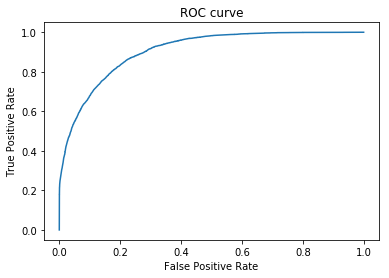

In [79]:
boosting(X_train, y_train)

## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

Calculate accuracy

In [80]:
(85+36)/(85+36+8+58)

0.6470588235294118

Calculate precision

In [81]:
36/(36+58)

0.3829787234042553

Calculate recall

In [82]:
36/(8+36)

0.8181818181818182

## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Experiment with feature selection, preprocessing, categorical encoding, and hyperparameter optimization, to try improving your cross-validation score.

### Part 3
Which model had the best cross-validation score? Refit this model on the train set and do a final evaluation on the held out test set — what is the test score? 

### Part 4
Calculate F1 score and False Positive Rate. 

In [0]:
  pipeline = make_pipeline(
  SimpleImputer(missing_values=np.NaN, strategy='most_frequent'),
  ce.OrdinalEncoder(), 
  StandardScaler(),
  RandomForestClassifier(max_depth=None, n_estimators=100, n_jobs=-1, random_state=42)
  )

In [94]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='most_frequent', verbose=0)), ('ordinalencoder', OrdinalEncoder(cols=[1, 3, 5, 6, 7, 8, 9, 13], drop_invariant=False,
        handle_missing='value', handle_unknown='value',
        mapping=[{'col'...imators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [95]:
pipeline.score(X_test, y_test)

0.8602794411177644